<a href="https://colab.research.google.com/github/sauravsingla/Multi-Class-Sentiment-Classification-/blob/main/twitter_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Flatten
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
import re
from pandas import DataFrame
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
#########  PREPROCESSING PART #################################################
df = pd.read_csv("/content/drive/My Drive/NLP/text_emotion.csv")
df = df.drop(["tweet_id","author"],axis = 1)
print(df.head())

    sentiment                                            content
0       empty  @tiffanylue i know  i was listenin to bad habi...
1     sadness  Layin n bed with a headache  ughhhh...waitin o...
2     sadness                Funeral ceremony...gloomy friday...
3  enthusiasm               wants to hang out with friends SOON!
4     neutral  @dannycastillo We want to trade with someone w...


In [ ]:
df['target'] = df['sentiment'].map({'sadness': 0, 'enthusiasm':1,'neutral':2,'worry':3,'surprise':4,'love':5,'fun':6,'hate':7,'happiness':8,'boredom':9,'relief':10,'anger':11,'empty':12})
print(df.head())

    sentiment                                            content  target
0       empty  @tiffanylue i know  i was listenin to bad habi...      12
1     sadness  Layin n bed with a headache  ughhhh...waitin o...       0
2     sadness                Funeral ceremony...gloomy friday...       0
3  enthusiasm               wants to hang out with friends SOON!       1
4     neutral  @dannycastillo We want to trade with someone w...       2


In [ ]:
df = df.drop(["sentiment"],axis=1)
print(df)

                                                 content  target
0      @tiffanylue i know  i was listenin to bad habi...      12
1      Layin n bed with a headache  ughhhh...waitin o...       0
2                    Funeral ceremony...gloomy friday...       0
3                   wants to hang out with friends SOON!       1
4      @dannycastillo We want to trade with someone w...       2
...                                                  ...     ...
39995                                   @JohnLloydTaylor       2
39996                     Happy Mothers Day  All my love       5
39997  Happy Mother's Day to all the mommies out ther...       5
39998  @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...       8
39999  @mopedronin bullet train from tokyo    the gf ...       5

[40000 rows x 2 columns]


In [ ]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
output = []
for sentence in df["content"]:
    temp_list = []
    for word in sentence.split():
      if word.lower() not in stopwords:
        temp_list.append(word)
    output.append(' '.join(temp_list))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df["clean"] = output
tw = []
for j in df['clean']:
  tweets = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", str(j)).split())
  tw.append(tweets)
df['cleaned'] = tw
df.head()

,content,target,clean,cleaned
0,@tiffanylue i know i was listenin to bad habi...,12,@tiffanylue know listenin bad habit earlier st...,know listenin bad habit earlier started freaki...
1,Layin n bed with a headache ughhhh...waitin o...,0,Layin n bed headache ughhhh...waitin call...,Layin n bed headache ughhhh waitin call
2,Funeral ceremony...gloomy friday...,0,Funeral ceremony...gloomy friday...,Funeral ceremony gloomy friday
3,wants to hang out with friends SOON!,1,wants hang friends SOON!,wants hang friends SOON
4,@dannycastillo We want to trade with someone w...,2,@dannycastillo want trade someone Houston tick...,want trade someone Houston tickets one will


In [ ]:
df = df.drop(["content","clean"],axis=1)
df.head()

,target,cleaned
0,12,know listenin bad habit earlier started freaki...
1,0,Layin n bed headache ughhhh waitin call
2,0,Funeral ceremony gloomy friday
3,1,wants hang friends SOON
4,2,want trade someone Houston tickets one will


In [ ]:
#Preprocessing of content before passing it to X
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def lemmatize_text(cleaned):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(cleaned)]


df['text_lemmatized'] = df.cleaned.apply(lemmatize_text)

sc = [[' '.join(i)] for i in df['text_lemmatized']]
lis = []
for i in sc:
    abc = i[0]
    lis.append(abc)

df3 = DataFrame (lis,columns=['texts'])

result = pd.concat([df, df3], axis=1, sort=False)

result = result.drop(['text_lemmatized'], axis=1)
result.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,target,cleaned,texts
0,12,know listenin bad habit earlier started freaki...,know listenin bad habit earlier started freaki...
1,0,Layin n bed headache ughhhh waitin call,Layin n bed headache ughhhh waitin call
2,0,Funeral ceremony gloomy friday,Funeral ceremony gloomy friday
3,1,wants hang friends SOON,want hang friend SOON
4,2,want trade someone Houston tickets one will,want trade someone Houston ticket one will


In [ ]:
result.drop(result[result['target'] == 12].index, inplace = True)
result.drop(result[result['target'] == 11].index, inplace = True)
result.head()

,target,cleaned,texts
1,0,Layin n bed headache ughhhh waitin call,Layin n bed headache ughhhh waitin call
2,0,Funeral ceremony gloomy friday,Funeral ceremony gloomy friday
3,1,wants hang friends SOON,want hang friend SOON
4,2,want trade someone Houston tickets one will,want trade someone Houston ticket one will
5,3,Re pinging go prom BC bf like friends,Re pinging go prom BC bf like friend


In [ ]:
X = result["texts"]
Y = result["target"]

In [ ]:
# some configuration
MAX_SEQUENCE_LENGTH = 20
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
BATCH_SIZE = 128
EPOCHS = 100

# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/drive/My Drive/NLP/glove.6B.%sd.txt' % EMBEDDING_DIM),encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(data,Y, test_size = 0.35)

Yt = np_utils.to_categorical(Ytrain)

Loading word vectors...
Found 400000 word vectors.
Found 28651 unique tokens.
Shape of data tensor: (39063, 20)


In [ ]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector
      
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(48, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(24, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = GlobalMaxPool1D()(x)
output = Dense(11, activation="softmax")(x)

model = Model(input_, output)
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)

model.summary()

Filling pre-trained embeddings...
Building model...
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 100)           2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 20, 64)            42240     
_________________________________________________________________
dropout (Dropout)            (None, 20, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 48)            21696     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 48)            0         
_________________________________________________________________
ls

Training model...
Epoch 1/15
139/139 [==============================] - 2s 17ms/step - loss: 2.1066 - accuracy: 0.2490 - val_loss: 2.0399 - val_accuracy: 0.2746
Epoch 2/15
139/139 [==============================] - 1s 10ms/step - loss: 1.9988 - accuracy: 0.2893 - val_loss: 1.9849 - val_accuracy: 0.3056
Epoch 3/15
139/139 [==============================] - 1s 11ms/step - loss: 1.9488 - accuracy: 0.3136 - val_loss: 1.9412 - val_accuracy: 0.3297
Epoch 4/15
139/139 [==============================] - 1s 10ms/step - loss: 1.9097 - accuracy: 0.3321 - val_loss: 1.9176 - val_accuracy: 0.3404
Epoch 5/15
139/139 [==============================] - 1s 11ms/step - loss: 1.8806 - accuracy: 0.3450 - val_loss: 1.8959 - val_accuracy: 0.3436
Epoch 6/15
139/139 [==============================] - 1s 11ms/step - loss: 1.8629 - accuracy: 0.3491 - val_loss: 1.8923 - val_accuracy: 0.3429
Epoch 7/15
139/139 [==============================] - 1s 10ms/step - loss: 1.8429 - accuracy: 0.3584 - val_loss: 1.8835 - va

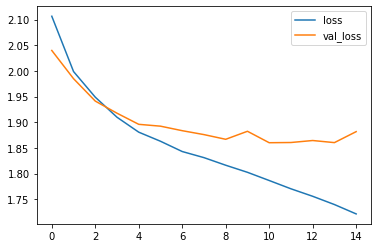

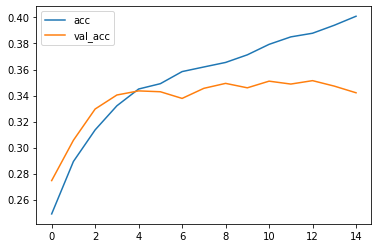

In [ ]:
print('Training model...')
r = model.fit(
  Xtrain,
  Yt,
  batch_size=BATCH_SIZE,
  epochs=15,
  validation_split=0.3
)


plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
p = model.predict(Xtest)
print(p)
p = np.argmax(p, axis=1)
print(p)

cnfv=confusion_matrix(Ytest,p)
print(cnfv)

print(classification_report(Ytest, p))

[[0.10476441 0.02308047 0.28092313 ... 0.04543789 0.00439782 0.03566249]
 [0.12528697 0.02338702 0.31237713 ... 0.06086471 0.00847049 0.04449126]
 [0.04315357 0.02459279 0.1821624  ... 0.33489707 0.00291872 0.07566664]
 ...
 [0.3941279  0.00679368 0.06184945 ... 0.01352695 0.00409527 0.01767237]
 [0.08065096 0.02703558 0.43777502 ... 0.08087239 0.00861767 0.0415142 ]
 [0.24835283 0.01093273 0.07563812 ... 0.01666507 0.00852737 0.02850085]]
[3 2 8 ... 0 2 3]
[[ 155    0  337 1148    2   35    0   62   75    0    0]
 [   5    0  103   91    0   12    0    4   33    0    0]
 [  34    0 1671  983    2   89    0   32  254    0    0]
 [  78    0  793 1794    1   72    0   80  134    0    1]
 [  14    0  284  294    1   47    0   16  100    0    0]
 [  28    0  300  279    1  482    0    7  285    0    0]
 [   8    0  231  219    1   36    0   10  129    0    0]
 [  11    0   66  282    0    2    0   71   14    0    0]
 [  18    0  608  449    4  153    2   18  528    0    0]
 [   2    0   13

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
